# Phonological features

This notebook explores what the trained phoneme-level models learn about phonological features. I break this down into four questions:

1. Do the models learn representations that are functionally equivalent to phonological features?
2. Do they learn similar (i.e. globally comparable) representations?
3. Do they learn interpretable representations?
4. Do they structure the space in a similar way to phonological features?

I answer each of these questions using various analyses, mostly with structural methods. I am also interested in how the answers to these questions vary with the following properties:

- Training size
- Epoch
- Language
- Model
- Dimensionality

In [1]:
%load_ext blackcellmagic
import os
from utils import ROOT
os.chdir(ROOT)
from models import all_trained_phoneme_models, performance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel, spearmanr

sns.set()

## Do the models learn representations that are functionally equivalent to phonological features?

To answer this question, I compare the intrinsic performance of the language models that learn their own representations and those that use ground truth representations. If the models that learn their own representations perform similarly to those that use ground truth representations, then this would suggest that the learnt representations are "doing the job" of the ground truth representations. If however the ground truth models perform much better than the learnt models, this would suggest the models are not learning functionally equivalent representations. As a measure of intrinsic performance, I use the perplexity on the test set.

In [31]:
# Read in performance results
models = all_trained_phoneme_models()
results = []
for model in models:
    # intrinsic performance (perplexity) only makes sense for true language models,
    # which in my case are the RNN models
    if "hidden" in model:
        model["ppl"] = performance(**model)
        results.append(model)
df = pd.DataFrame(results)
for column in ["level", "lg", "name"]:
    df[column] = df[column].astype("category")
for column in ["hidden", "epoch"]:
    df[column] = df[column].astype(int)
uses_ground_truth = df["size"] == "groundTruth"
ground_truth = df[uses_ground_truth]
learnt = df[~uses_ground_truth]
merged = pd.merge(
    learnt,
    ground_truth,
    on=["level", "lg", "name", "hidden", "epoch"],
    how="inner",
    suffixes=("_learnt", "_true"),
)
merged["size_learnt"] = merged["size_learnt"].astype(int)
merged["ppl_delta"] = merged["ppl_true"] - merged["ppl_learnt"]
merged["ppl_delta_percent"] = (merged["ppl_delta"] / merged["ppl_true"]) * 100

# Add training size data
def training_size(lg):
    filename = f"data/phoneme/wikipron/{lg}/train.txt"
    with open(filename) as file:
        contents = file.read()
    return contents.count("\n") + 1

merged["n"] = merged["lg"].apply(training_size)
merged

,level,lg,name,size_learnt,hidden,epoch,ppl_learnt,size_true,ppl_true,ppl_delta,ppl_delta_percent,n
0,phoneme,cat,rnn,30,20,0,19.150223,groundTruth,19.880260,0.730038,3.672174,43200
1,phoneme,cat,rnn,20,20,0,18.970442,groundTruth,19.880260,0.909819,4.576493,43200
2,phoneme,cat,rnn,10,20,0,21.144991,groundTruth,19.880260,-1.264730,-6.361740,43200
3,phoneme,cat,rnn,5,20,0,20.440744,groundTruth,19.880260,-0.560484,-2.819299,43200
4,phoneme,cat,rnn,30,20,1,17.279394,groundTruth,18.229013,0.949619,5.209384,43200
...,...,...,...,...,...,...,...,...,...,...,...,...
9541,phoneme,afr,lstm,5,50,8,12.898238,groundTruth,12.584450,-0.313788,-2.493462,1031
9542,phoneme,afr,lstm,30,50,9,11.695046,groundTruth,12.342327,0.647281,5.244397,1031
9543,phoneme,afr,lstm,20,50,9,11.589212,groundTruth,12.342327,0.753115,6.101886,1031
9544,phoneme,afr,lstm,10,50,9,12.751270,groundTruth,12.342327,-0.408943,-3.313339,1031


In [99]:
def relationship_between_performance_delta_and_hyperparams(sizes, hiddens, names):
    # Restrict analysis to certain models
    size_restriction = merged["size_learnt"].isin(sizes)
    hidden_restriction = merged["hidden"].isin(hiddens)
    model_restriction = merged["name"].isin(names)
    subset = merged[size_restriction & hidden_restriction & model_restriction]
    performance_delta_by_lg = subset.groupby("lg")[["ppl_delta_percent", "n"]].mean()
    grid = sns.scatterplot(data=performance_delta_by_lg, x="n", y="ppl_delta_percent")
    grid.set(xscale="log")
    return grid

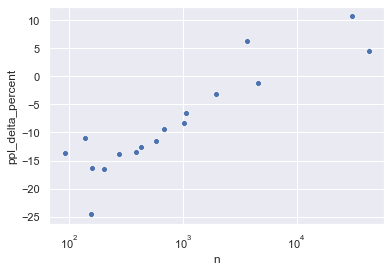

In [101]:
relationship_between_performance_delta_and_hyperparams(
    [5, 10, 20, 30], [10, 20, 30, 50], ["rnn", "lstm", "gru"]
);

Relationship between training data size and relative improvement when using learnt representations. Positive values on the Y axis indicate improved performance when using learnt representations over using ground truth representations. There is a clear upward trend showing that the use of learnt representations improves performance as a function of the training size. When there is small amounts of training data, learning representations degrades performance. When there is sufficient training data, learning representations is superior to the featural representations. This suggests that the learnt representations are functionally equivalent to the explicit representations. This is consistent with a similar result in Pimentel et al. (2020).

The plots below probe the robustness of this result by subsetting the analysis. We see that the same trend holds true when subsetted by the dimensionality of the embeddings and the hidden layer, as well as the model class.

In [94]:
# Explore the above relationship in subsets
def relationship_between_performance_delta_and_hyperparams_subset(
    sizes, hiddens, names, by
):
    # Restrict analysis to certain models
    size_restriction = merged["size_learnt"].isin(sizes)
    hidden_restriction = merged["hidden"].isin(hiddens)
    model_restriction = merged["name"].isin(names)
    subset = merged[size_restriction & hidden_restriction & model_restriction]
    performance_delta_by_lg = (
        subset.groupby(["lg", by])[["ppl_delta_percent", "n"]].mean().reset_index()
    )
    grid = sns.FacetGrid(data=performance_delta_by_lg, col=by, col_wrap=2)
    grid = grid.map(sns.scatterplot, "n", "ppl_delta_percent")
    grid.set(xscale="log")
    return grid

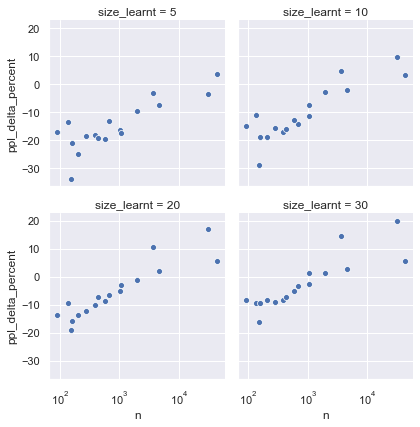

In [96]:
relationship_between_performance_delta_and_hyperparams_subset(
    [5, 10, 20, 30], [10, 20, 30, 50], ["rnn", "lstm", "gru"], "size_learnt"
);

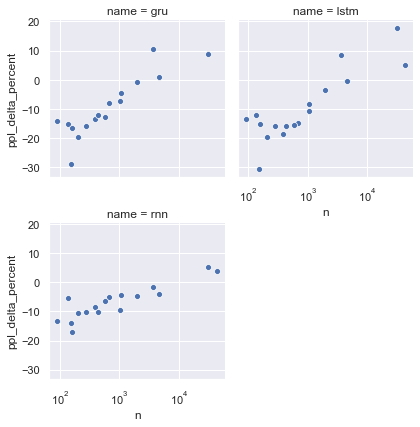

In [98]:
relationship_between_performance_delta_and_hyperparams_subset(
    [5, 10, 20, 30], [10, 20, 30, 50], ["rnn", "lstm", "gru"], "name"
);

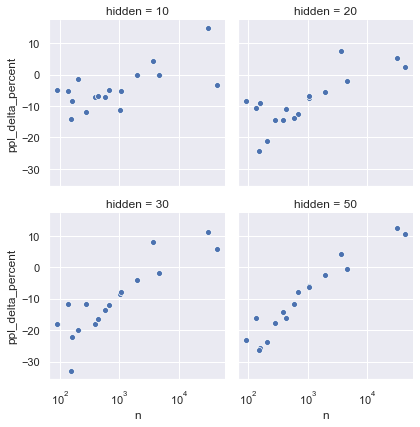

In [102]:
relationship_between_performance_delta_and_hyperparams_subset(
    [5, 10, 20, 30], [10, 20, 30, 50], ["rnn", "lstm", "gru"], "hidden"
);

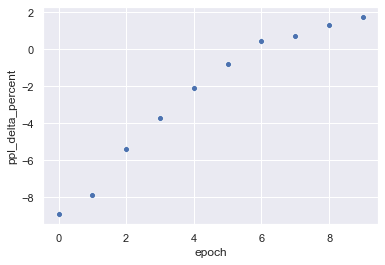

In [119]:
# Explore the above relationship by epoch
sizes = [5, 10, 20, 30]
hiddens = [10, 20, 30, 50]
names = ["rnn", "lstm", "gru"]
threshold = 500
# Restrict analysis to certain models
size_restriction = merged["size_learnt"].isin(sizes)
hidden_restriction = merged["hidden"].isin(hiddens)
model_restriction = merged["name"].isin(names)
threshold_restriction = merged["n"] > threshold
subset = merged[size_restriction & hidden_restriction & model_restriction & threshold_restriction]
performance_delta_by_lg = (
    subset.groupby("epoch")[["ppl_delta_percent", "n"]].mean().reset_index()
)
sns.scatterplot(data=performance_delta_by_lg, x="epoch", y="ppl_delta_percent")
grid.set(xscale="log");

This plot shows that the result holds across epochs as well. That is, the longer you train, the more improvement you get from learning your own representations.

## Correlation of dissimilarity

In [122]:
def read_correlation(**kwargs):
    assert "size" != "groundTruth", "This doesn't make sense for ground truth representations"
    lg, name, epoch = kwargs["lg"], kwargs["name"], kwargs["epoch"]
    if "hidden" in kwargs:
        hyperparams = f"{kwargs['size']}-{kwargs['hidden']}"
    else:
        hyperparams = f"{kwargs['size']}-{kwargs['window']}"
    filename = f"results/phoneme/correlation/{lg}/{name}/{hyperparams}/{epoch}.txt"
    with open(filename) as file:
        contents = file.read()
    r, p = eval(contents)
    return r, p

In [123]:
results = []
for model in models:
    try:
        r, p = read_correlation(**model)
        model_copy = model.copy()
        model_copy["r"], model_copy["p"] = r, p
        if "hidden" in model:
            ppl = performance(**model)
            model_copy["ppl"] = ppl
        results.append(model_copy)
    except FileNotFoundError:
        continue
df = pd.DataFrame(results)
df["n"] = df["lg"].apply(training_size)
df["size"] = df["size"].astype(int)
df

,level,lg,name,size,hidden,epoch,r,p,ppl,window,n
0,phoneme,cat,gru,10,10,0,0.583714,1.945843e-33,17.290003,NaN,43200
1,phoneme,cat,gru,10,10,1,0.583714,1.945843e-33,16.192991,NaN,43200
2,phoneme,cat,gru,10,10,2,0.583714,1.945843e-33,15.326177,NaN,43200
3,phoneme,cat,gru,10,10,3,0.583714,1.945843e-33,14.832352,NaN,43200
4,phoneme,cat,gru,10,10,4,0.583714,1.945843e-33,14.583613,NaN,43200
...,...,...,...,...,...,...,...,...,...,...,...
10843,phoneme,ind,word2vec,5,NaN,3,-0.068493,1.683713e-01,NaN,2.0,1155
10844,phoneme,ind,word2vec,5,NaN,2,-0.068493,1.683713e-01,NaN,2.0,1155
10845,phoneme,ind,word2vec,5,NaN,1,-0.068493,1.683713e-01,NaN,2.0,1155
10846,phoneme,ind,word2vec,20,NaN,10,-0.113470,2.221378e-02,NaN,1.0,1155


In [114]:
df.groupby("n").apply(lambda g: spearmanr(g["r"], g["ppl"])[0])

n
91      -0.371513
137     -0.194160
154     -0.244237
158     -0.333660
174     -0.352455
204     -0.373570
276     -0.077379
386     -0.402462
431     -0.403378
582     -0.192688
675     -0.006916
1064    -0.020135
1971     0.109166
3663    -0.099096
4554    -0.131560
8650          NaN
43200    0.291142
dtype: float64

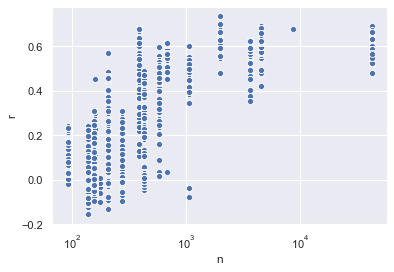

In [117]:
grid = sns.scatterplot(data=df, x="n", y="r")
grid.set(xscale="log");